# Lets See How The Disc Models Preformed

This notebook is designed to analyze the disc models performance and to answer the question does Long Short Term Memory Neural Net (LSTM) outperform SparseLogisticRegression (SLR).

## MUST RUN AT THE START OF EVERYTHING

Load the database and other helpful functions for analysis.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import csv
import glob
import os

from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc, f1_score, confusion_matrix
import tqdm

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.annotations import FeatureAnnotator, LabelAnnotator, load_marginals
from snorkel.learning import SparseLogisticRegression
from snorkel.learning.disc_models.rnn import reRNN
from snorkel.learning.utils import RandomSearch
from snorkel.models import Candidate, FeatureKey, candidate_subclass
from snorkel.utils import get_as_dict
from snorkel.viewer import SentenceNgramViewer
from sqlalchemy import and_
from tree_structs import corenlp_to_xmltree
from treedlib import compile_relation_feature_generator

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
edge_type = "dg"

In [5]:
if edge_type == "dg":
    DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])
elif edge_type == "gg":
    GeneGene = candidate_subclass('GeneGene', ['Gene1', 'Gene2'])
elif edge_type == "cg":
    CompoundGene = candidate_subclass('CompoundGene', ['Compound', 'Gene'])
elif edge_type == "cd":
    CompoundDisease = candidate_subclass('CompoundDisease', ['Compound', 'Disease'])
else:
    print("Please pick a valid edge type")

# Load the data

Here is where we load the test dataset in conjunction with the previously trained disc models. Each algorithm will output a probability of a candidate being a true candidate.

In [6]:
from snorkel.annotations import load_gold_labels

L_gold_dev = load_gold_labels(session, annotator_name='danich1', split=1)
Y = L_gold_dev[L_gold_dev != 0].todense()

In [7]:
print(pd.Series(Y.tolist()[0]).value_counts())

-1    185
 1    121
dtype: int64


In [8]:
marginal_files = [
    "vanilla_lstm/lstm_disease_gene_holdout/subsampled/lf_marginals/hand_LR_dev_marginals.csv",
    "vanilla_lstm/lstm_disease_gene_holdout/subsampled/lf_marginals/all_LF_LR_dev_marginals.csv"
]

file_labels = [
    "HUMAN_BW_LR",
    "LF_BW_LR"
]

model_labels = [
    "HUMAN_BW_LR",
    "LF_BW_LR",
]

model_colors = [
    "red",
    "blue",
]

In [9]:
model_marginals = pd.DataFrame(Y.T, columns=["True_Labels"])
for marginal_label, marginal_file in zip(file_labels, marginal_files):
    model_marginals[marginal_label] = pd.read_csv(marginal_file)

model_marginals.head(10)

,True_Labels,HUMAN_BW_LR,LF_BW_LR
0,-1,0.842523,0.929883
1,-1,0.189424,0.840748
2,-1,0.988136,0.967259
3,-1,0.988136,0.967259
4,1,0.373528,0.957499
5,1,0.373528,0.957499
6,1,0.425185,0.884804
7,-1,0.095621,0.916073
8,-1,0.182533,0.798097
9,-1,0.484129,0.920681


In [10]:
#test_set = pd.read_csv("stratified_data/lstm_disease_gene_holdout/test_candidates_sentences.csv")

# Accuracy ROC

From the probabilities calculated above, we can create a [Receiver Operator Curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) (ROC) graph to measure the false positive rate and the true positive rate at each calculated threshold.

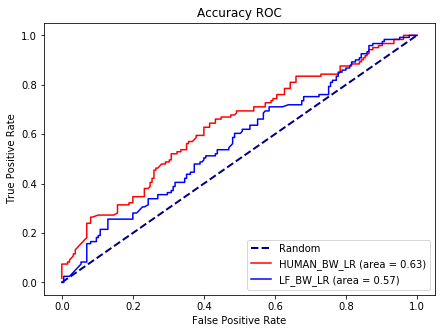

In [11]:
marginal_labels = [col for col in model_marginals.columns if col != "True_Labels"]
plt.figure(figsize=(7,5))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

for marginal_label, model_label, model_color in zip(marginal_labels, model_labels, model_colors):
    fpr, tpr, _= roc_curve(model_marginals["True_Labels"], model_marginals[marginal_label])
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=model_color, label="{} (area = {:0.2f})".format(model_label, model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Accuracy ROC')
plt.legend(loc="lower right")

# Precision vs Recall Curve

This code produces a [Precision-Recall](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) graph, which shows the trade off between [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) at each given probability threshold.

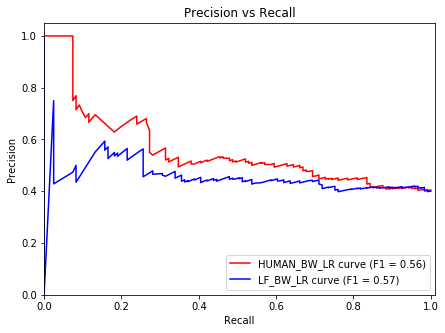

In [12]:
marginal_labels = [col for col in model_marginals.columns if col != "True_Labels"]
plt.figure(figsize=(7,5))

for marginal_label, model_label, model_color in zip(marginal_labels, model_labels, model_colors):
    precision, recall, _ = precision_recall_curve(model_marginals["True_Labels"], model_marginals[marginal_label])
    model_precision = average_precision_score(model_marginals["True_Labels"], model_marginals[marginal_label])
    model_f1 = f1_score(model_marginals["True_Labels"], list(map(lambda x: 1 if x > 0.5 else -1, model_marginals[marginal_label])))
    plt.plot(recall, precision, color=model_color, label="{} curve (F1 = {:0.2f})".format(model_label, model_f1))

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision vs Recall')
plt.xlim([0, 1.01])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")

# LSTM BENCHMARKING

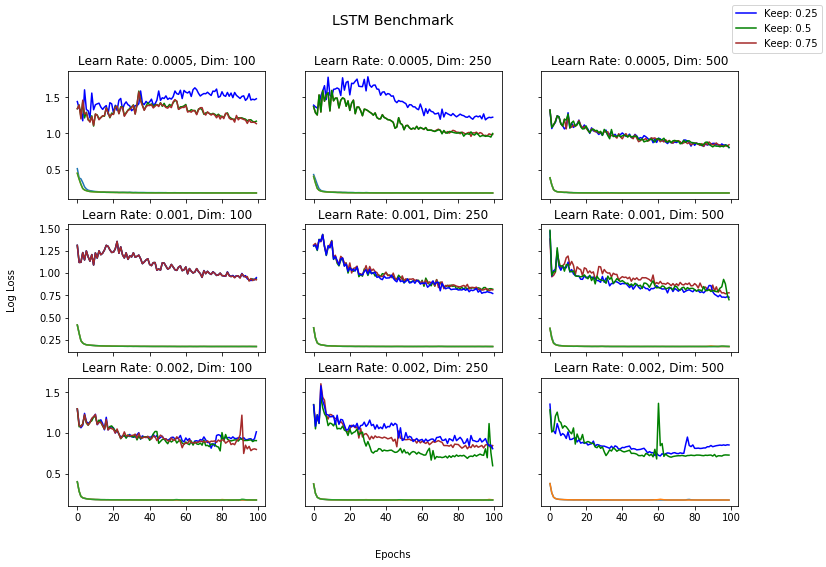

In [13]:
import glob
import os
f, ax = plt.subplots(3,3, sharex='col', sharey='row', figsize=(12,8))
color_map = {
    "0.25":"blue",
    "0.5":"green",
    "0.75":"brown"
}
#Make graph learning rate by dimension
index = 1
for row, dimension in enumerate([100, 250,500]):
    for col, lr in enumerate([0.0005, 0.001, 0.002]):
        for diagnostics_file in glob.glob(r"vanilla_lstm/benchmark/no_dropout/lstm_{}_*_{}.tsv".format(lr, dimension)):
            benchmark_label = os.path.splitext(os.path.basename(diagnostics_file))[0]
            benchmark_label = re.search(r'_(\d\.\d\d?)_', benchmark_label).group(1)
            
            diagnostics_df = pd.read_table(diagnostics_file)
            ax[col][row].plot(diagnostics_df["train_loss"], label="_no_legend_")
            ax[col][row].plot(diagnostics_df["val_loss"], label="Keep: {}".format(benchmark_label), color=color_map[benchmark_label])
        ax[col][row].set_title("Learn Rate: {}, Dim: {}".format(lr, dimension))
        if col==0 and row == 0:
            f.legend()
        index += 1
f.text(0.5, 0.04, 'Epochs', ha='center', va='center')
f.text(0.06, 0.5, 'Log Loss', ha='center', va='center', rotation='vertical')
f.suptitle("LSTM Benchmark", fontsize=14)
#plt.xlim([0,105])
#plt.ylim([0,0.3])
#plt.xlabel("Epochs")
#plt.ylabel("Log Loss")
plt.show()

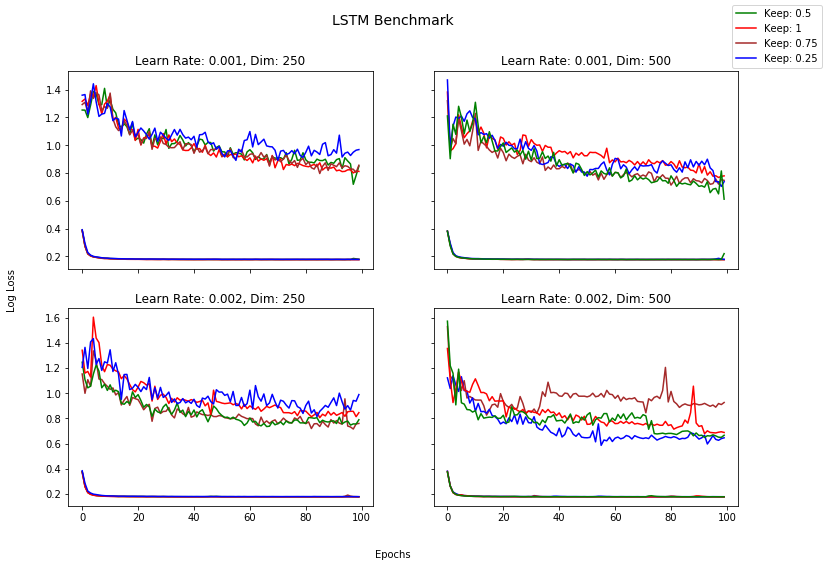

In [14]:
import glob
import os
f, ax = plt.subplots(2,2, sharex='col', sharey='row', figsize=(12,8))
color_map = {
    "1":"red",
    "0.25":"blue",
    "0.5":"green",
    "0.75":"brown"
}
legend_dict = {}
#Make graph learning rate by dimension
index = 1
for row, dimension in enumerate([250,500]):
    for col, lr in enumerate([0.001, 0.002]):
        for diagnostics_file in glob.glob(r"vanilla_lstm/benchmark/dropout/lstm_{}_*_{}.tsv".format(lr, dimension)):
            benchmark_label = os.path.splitext(os.path.basename(diagnostics_file))[0]
            benchmark_label = re.search(r'_(\d\.?\d?\d?)_', benchmark_label).group(1)

            diagnostics_df = pd.read_table(diagnostics_file)
            ax[col][row].plot(diagnostics_df["train_loss"], color=color_map[benchmark_label], label='_nolegend_')
            ax[col][row].plot(diagnostics_df["val_loss"], label="Keep: {}".format(benchmark_label), color=color_map[benchmark_label])
        ax[col][row].set_title("Learn Rate: {}, Dim: {}".format(lr, dimension))
        #ax[col][row].legend()
        index += 1
        if col == 0 and row == 0:
            f.legend()
        #ax[col][row].set_ylim([0.175,0.2])
f.text(0.5, 0.04, 'Epochs', ha='center', va='center')
f.text(0.06, 0.5, 'Log Loss', ha='center', va='center', rotation='vertical')
f.suptitle("LSTM Benchmark", fontsize=14)
plt.show()

## LSTM Model Analysis

In [ ]:
marginal_criteria = "RNN_100_Marginals"
model_predictions = model_marginals[marginal_criteria].apply(lambda x: 1 if x > 0.5 else -1)
model_predictions.head(10)

In [ ]:
condition = (model_predictions == 1)&(model_marginals["True_Labels"] == -1)
model_marginals[condition].sort_values(marginal_criteria, ascending=False).head(10)

In [ ]:
def insert(x, g_start, g_end, d_start, d_end, proba, d_cid, g_cid):
    if d_start == x[0] or g_start == x[0]:
        pos_str = "<span title=\"{}\" style=\"background-color: rgba(0,255,0,{})\">{}"
        neg_str = "<span title=\"{}\" style=\"background-color: rgba(255,0,0,{})\">{}"
        if proba > 0.5:
            return pos_str.format(d_cid, proba, x[1]) if d_start == x[0] else pos_str.format(g_cid, proba, x[1])
        else:
            return neg_str.format(d_cid, 1-proba, x[1]) if d_start == x[0] else neg_str.format(g_cid, 1-proba, x[1])
    elif d_end == x[0] or g_end == x[0]:
            return "{}</span>".format(x[1])
    else:
        return x[1]

## Look at the Sentences and the LSTM's predictions

In [ ]:
html_string = ""
counter = 0
sorted_marginals = (
     model_marginals.query("@model_predictions ==1 & True_Labels == -1")
                    .sort_values(marginal_criteria, ascending=False)
)

for cand_index, marginal in tqdm.tqdm(sorted_marginals[marginal_criteria].iteritems()):
    cand = test_set.iloc[cand_index]
    counter += 1
    
    if counter == 10:
        break
        
    if counter > 0:
        gene_start = cand["gene_char_start"]
        gene_end = cand["gene_char_end"]
        disease_start = cand["disease_char_start"]
        disease_end = cand["disease_char_end"]
        letters = []

        for x in enumerate(cand["sentence"]):
            letters.append(insert(x, gene_start, gene_end, disease_start, disease_end, marginal, cand["disease_id"], cand["gene_id"]))

        html_string += "<div title=\"{}\">{}</div><br />".format(marginal, ''.join(letters))

In [ ]:
with open("html/candidate_viewer.html", 'r') as f:
    display(HTML(f.read().format(html_string)))

# Write Results to CSV

In [ ]:
model_marginals.to_csv("stratified_data/lstm_disease_gene_holdout/total_test_marginals.csv", index=False)